# Flood Detector Training Notebook
This is the training notebook for the Flood Detector. The detector will use a pretrained model (*MobileNetV2*) to detected floodings on satellite imagery. The Training data (*Sen1Floods11*) is provived by the company *CloudToStreet* and was downloaded from Google Cloud Service.

To get an overview about the preprocessing, take a look at `FloodDetectorPreprocess.ipynb`.

In [1]:
%matplotlib inline

**Note**: How to connect via SHH: <br>
```
jupyter notebook --no-browser --port xxxx
ssh -NL xxxx:localhost:xxxx 192.168.0.xxx
```

Import the relevant Python and Custom modules

In [2]:
import os
import numpy as np

import tensorflow.keras.losses as losses
import tensorflow.keras.callbacks as callbacks
import tensorflow.keras.metrics as metrics
import tensorflow.keras.optimizers as optim

In [3]:
import daPro
import customMetrics as cMetrics
import customCallbacks as cCallbacks
import floodDetectorModel as floodDetector

import importlib
importlib.reload(floodDetector)
importlib.reload(daPro)
importlib.reload(cMetrics)

<module 'customMetrics' from '/home/vincent/WIDnet/FloodDetector/customMetrics.py'>

---

### Data Paths

In [4]:
### Paths ###
DS_PATH_ROOT = "../../Sen1Floods11/data/v1.1/"
DATA_PATH_ROOT = DS_PATH_ROOT + "data/"
DATA_PATH_IMAGES = DATA_PATH_ROOT + "flood_events/HandLabeled/S1Hand/"
DATA_PATH_LABELS = DATA_PATH_ROOT + "flood_events/HandLabeled/LabelHand/"

DS_PATH_SPLIT = DS_PATH_ROOT + "splits/flood_handlabeled/"
DS_PATH_SPLIT_TRAIN = DS_PATH_SPLIT + "flood_train_data.csv"
DS_PATH_SPLIT_VALID = DS_PATH_SPLIT + "flood_valid_data.csv"
DS_PATH_SPLIT_TEST  = DS_PATH_SPLIT + "flood_test_data.csv"

# proof path existence
assert os.path.exists(DATA_PATH_ROOT), DATA_PATH_ROOT + " does not exist"

### Load data
Note that the notebook `FloodDetectorPreprocess.ipynb` has a detailed description of the data preparation.

In [5]:
imageLoader = daPro.ImageLoader(DATA_PATH_IMAGES, DATA_PATH_LABELS, add_ratio_channel=True, tile_factor=None, nan=0, unsigend_labels=True)

ds_train_Img, ds_train_GT = imageLoader.load_ds(DS_PATH_SPLIT_TRAIN)
ds_valid_Img, ds_valid_GT = imageLoader.load_ds(DS_PATH_SPLIT_VALID)
ds_test_Img, ds_test_GT   = imageLoader.load_ds(DS_PATH_SPLIT_TEST)

252  Images were found.
89  Images were found.
90  Images were found.


In [6]:
linearNorm = daPro.LinearNorm.withPercentiles(ds_train_Img, 0.1, 99)

ds_train_Img_norm = linearNorm.norm(ds_train_Img)
ds_valid_Img_norm = linearNorm.norm(ds_valid_Img)
ds_test_Img_norm  = linearNorm.norm(ds_test_Img)

ds_train_GT_norm = ds_train_GT
ds_valid_GT_norm = ds_valid_GT
ds_test_GT_norm = ds_test_GT

Min Scaling Limits:  [-29.26355601 -46.99043655 -20.        ]  - Max Scaling Limits:  [0. 0. 0.]


In [7]:
#daPro.plot_rand_imgs(3, ds_train_Img_norm, ds_train_GT, id_of_interest=[72, 82, 18], pos_bound=True);

Pixel Distribution: No Data: 0.13, No Water: 0.78, Water: 0.08.
Recommended Weights:  [0, 1, 9.52010993136633] 



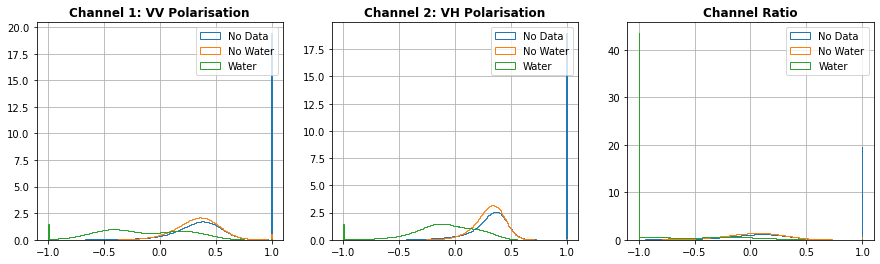

In [8]:
daPro.plot_pixel_dstr_per_ch(ds_train_Img_norm, ds_train_GT, pos_bound=True)

---
## Simple Threshold Model as Baseline

Before we start with designing the model and training, we will create a simple baseline model. This model will make a prediction based on threshold values of the `VV` and `VH` polarisation. We use the values `[-14dB, -20dB]` for the backscatter coeffiecient for creating the simple classifier. This model is super fast, but most likely not very precise. <br> Anyway, it will serve to get a first impression .

In [9]:
thresholds = linearNorm.normPixel([-14, -20])
thresholdModel = floodDetector.ThresholdClassifier(thresholds)
preds = thresholdModel.predict(ds_test_Img_norm)

In [10]:
iou = cMetrics.SparseMeanIoU(num_classes=3)
iou.update_state(ds_test_GT_norm, preds, sample_weight=daPro.create_sample_weights(ds_test_GT_norm, weights=[0,1,1]))
print("IoU Score of threshold based classifier: ", iou.result().numpy())

2022-03-29 12:18:58.703592: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3368 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 960, pci bus id: 0000:01:00.0, compute capability: 5.2


IoU Score of threshold based classifier:  0.4285842


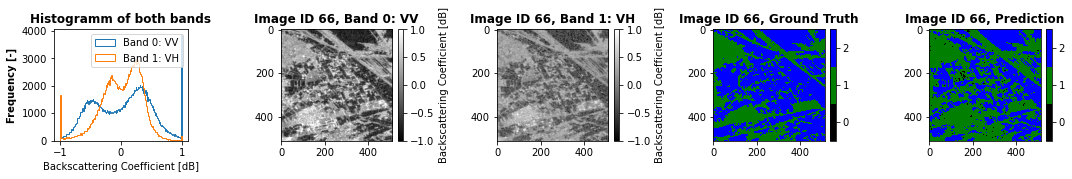

In [11]:
daPro.plot_rand_imgs(1, ds_test_Img_norm, ds_test_GT_norm, preds, id_of_interest=[66], savepath='plots/predictions.png');

---
## Model Design

The model will have a modified U-NET Architecture. To reduce the number of weights and thereby reduce the number of training parameters, we will take advantage of transfer learning. As encoder, a pretrained model will be used. In the first flood detector version, the model will be MobileNetV2. As decoder, multiple custom upsample layers will be used. Additionally, skip connectors from layers in the encoder will connect layers of the decoder (U-NET). 

In [12]:
INPUT_SHAPE = ds_test_Img_norm[0].shape

LR = 1e-3
OPTIMIZER = optim.Adam(learning_rate=LR)
LOSS = losses.SparseCategoricalCrossentropy(from_logits=True)
METRICS = [
    metrics.SparseCategoricalAccuracy(name="sparse_categorical_accuracy"),
]
WEIGHTED_METRICS = [
    cMetrics.SparseMeanIoU(num_classes=3, name="sparse_mean_io_u")
]

In [13]:
flood_detector = floodDetector.create_UNET(INPUT_SHAPE, name="Flood_Detector")

In [14]:
flood_detector.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS,  #METRICS
    weighted_metrics=WEIGHTED_METRICS
)

In [35]:
#flood_detector.summary()

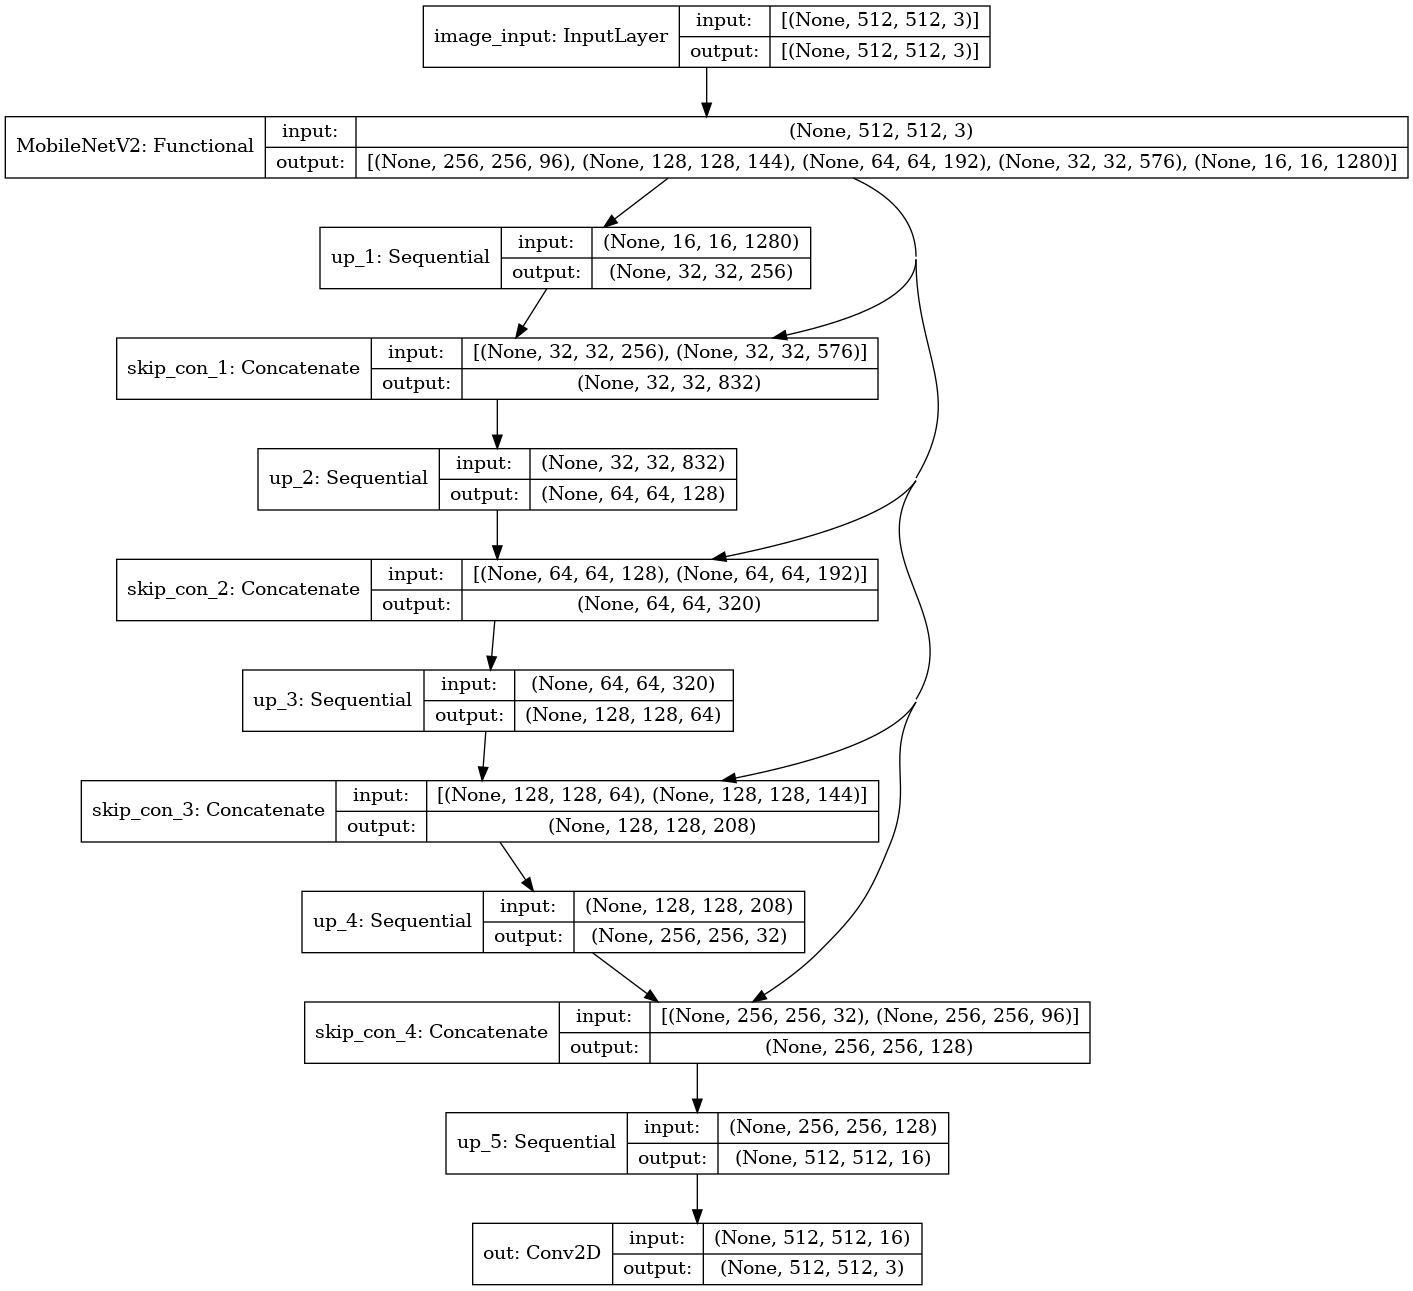

In [34]:
from tensorflow.keras.utils import plot_model
plot_model(flood_detector, show_shapes=True, expand_nested=False)

---

### Training

In [17]:
# resume training if desired
#flood_detector = load_model("flood_prediction.h5", custom_objects={"SparseMeanIoU" : SparseMeanIoU})

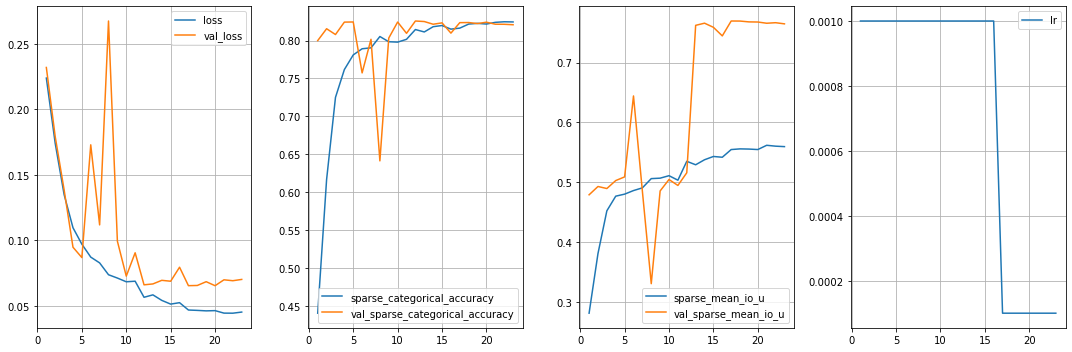

Epoch 00023: early stopping


In [19]:
CALLBACKS = [
    callbacks.ModelCheckpoint("flood_prediction_train.h5", moitor='val_sparse_mean_io_u', save_best_only=True),
    callbacks.CSVLogger("logs/training.log"),
    callbacks.EarlyStopping(monitor='val_sparse_mean_io_u', patience=15, verbose=True),
    callbacks.ReduceLROnPlateau(monitor='val_sparse_mean_io_u', patience=8, verbose=True),
    #callbacks.TerminateOnNaN(),
    cCallbacks.PlotTrainingProgress(),
    #cCallbacks.ShowSegmentationPrediction(),
]

WEIGHTS = [0, 1, 4]

history = flood_detector.fit(
    ds_train_Img_norm, 
    ds_train_GT_norm, 
    batch_size=4,
    #steps_per_epoch=2,
    sample_weight=daPro.create_sample_weights(ds_train_GT_norm, weights=WEIGHTS),
    validation_data=(ds_valid_Img_norm, ds_valid_GT_norm, daPro.create_sample_weights(ds_valid_GT_norm, weights=[0,1,1])), 
    epochs=50, 
    verbose=True,
    callbacks=CALLBACKS,
);

In [20]:
preds = flood_detector.predict(ds_test_Img_norm, batch_size=8, verbose=True)

2022-03-29 12:27:33.086885: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 283115520 exceeds 10% of free system memory.


12/12 [==============================] - 17s 465ms/step


In [21]:
evalue = flood_detector.evaluate(ds_test_Img_norm, ds_test_GT_norm, batch_size=8, verbose=True, sample_weight=daPro.create_sample_weights(ds_test_GT_norm, weights=[0,1,1]))

12/12 [==============================] - 12s 312ms/step - loss: 0.0742 - sparse_categorical_accuracy: 0.8185 - sparse_mean_io_u: 0.7773


We reach a Mean IoU score of `0.77` for the test set. Let's take a look at the predicted segmentations.

In [22]:
#iou = cMetrics.SparseMeanIoU(num_classes=3)
#print(iou.update_state(ds_test_GT_norm, preds, sample_weight=daPro.create_sample_weights(ds_test_GT_norm, weights=[0,1,1])))
#print("IoU Score: ", iou.result().numpy())

In [23]:
preds = np.array(preds[0])  # What happend? model.predict returns a tuple isnstead of an nparray now?

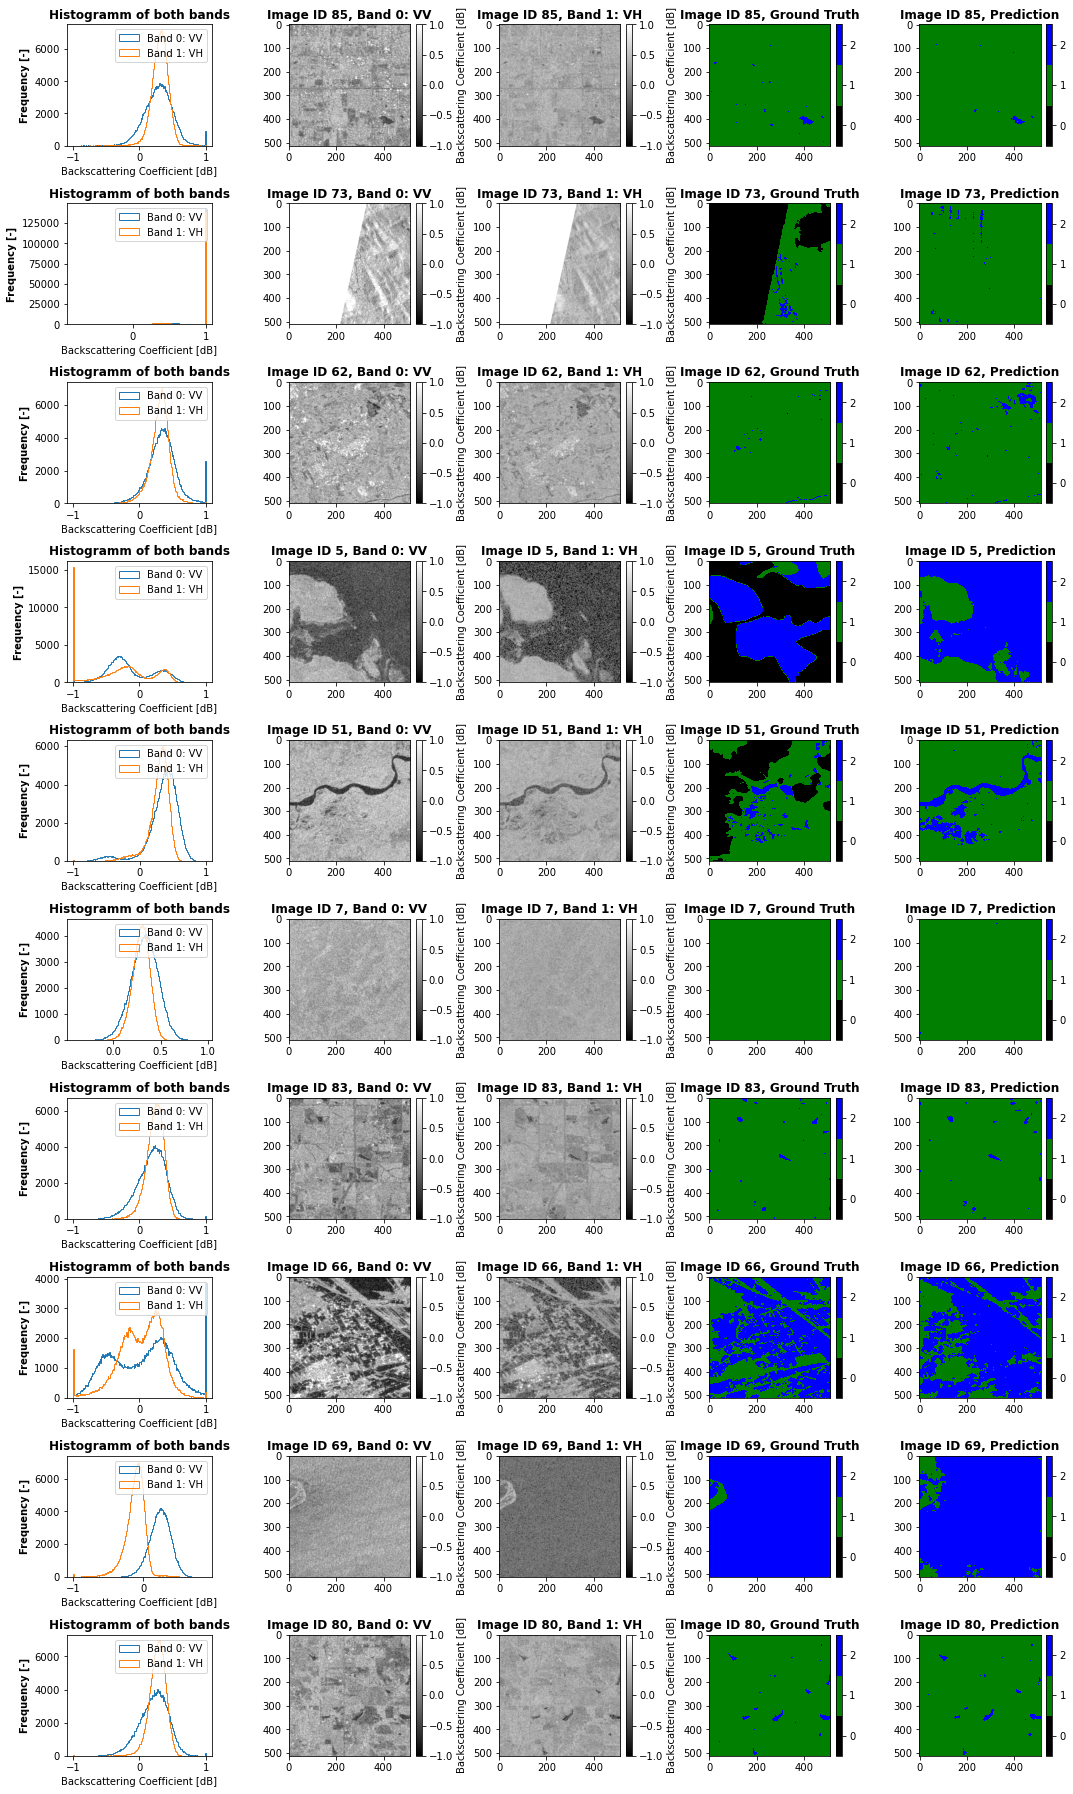

In [36]:
#daPro.plot_rand_imgs(10, ds_train_Img_norm, ds_train_GT_norm, preds, savepath='plots/predictions.png');
daPro.plot_rand_imgs(10, ds_test_Img_norm, ds_test_GT_norm, preds, savepath='plots/predictions.png');

---

**ToDO: move the section below in a notebook called `FloodDetectorInferenece.ipynb`**

### Load Model from h5 file

In [25]:
from tensorflow.keras.models import load_model
flood_detector_h5 = load_model("flood_prediction_train.h5", custom_objects={"SparseMeanIoU" : cMetrics.SparseMeanIoU})

In [26]:
preds_h5 = flood_detector_h5.predict(ds_test_Img_norm, batch_size=16, verbose=True)

6/6 [==============================] - 30s 2s/step


In [27]:
evalue_h5 = flood_detector_h5.evaluate(ds_test_Img_norm, ds_test_GT_norm, batch_size=8, verbose=True, sample_weight=daPro.create_sample_weights(ds_test_GT_norm, weights=[0,1,1]))

12/12 [==============================] - 5s 255ms/step - loss: 0.0701 - sparse_categorical_accuracy: 0.8219 - sparse_mean_io_u: 0.7824


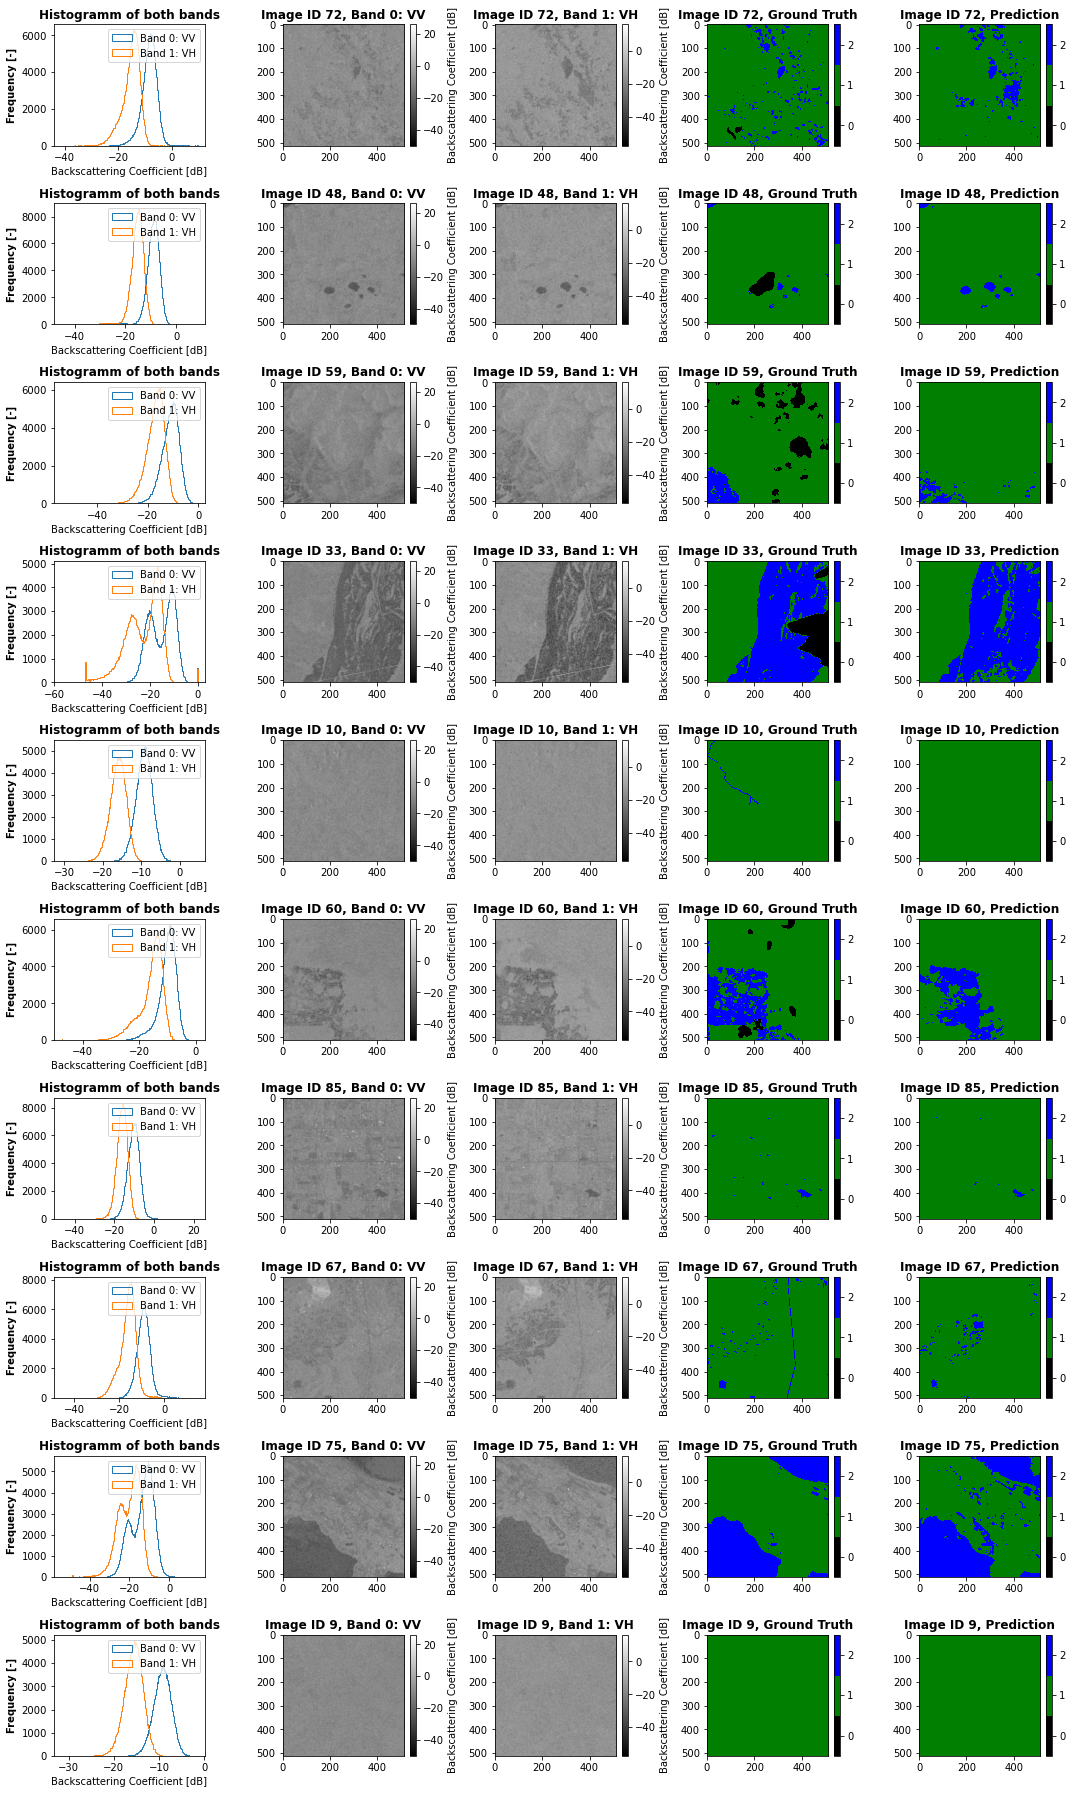

In [28]:
daPro.plot_rand_imgs(10, ds_test_Img, ds_test_GT_norm, preds_h5, savepath='plots/predictionsh5.png');

### Some evaluation stuff .. 

img 3 	 Max: 2.00, Where: (0, 2) 	 with logits:  [-3.9754572  1.0184401  1.6015712] 	 Min: 1.00, 	 Type uint8


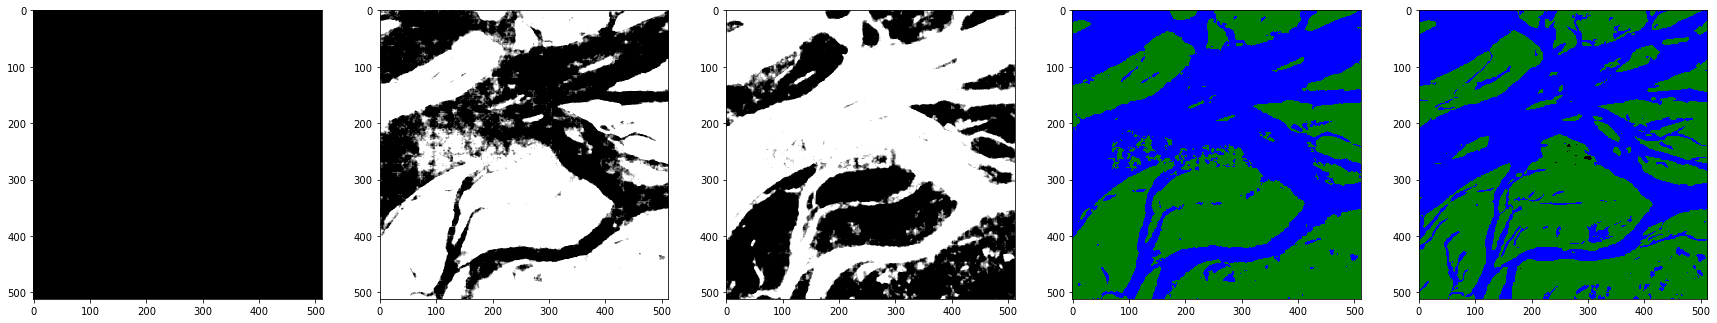

In [32]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.cm import get_cmap, ScalarMappable

for i, img in enumerate(preds_h5[12:13]):
    mask = daPro.create_mask(img)
    i_max = np.unravel_index(mask[:,:,0].argmax(), mask[:,:,0].shape)
    
    print(f"img {i+3} \t Max: {mask[:,:,0].max():4.2f}, Where: {i_max} \t with logits:  {img[i_max]} \t Min: {mask[:,:,0].min():4.2f}, \t Type {mask.dtype}")
    
# create custom colormap for labeled images.
gt_range = [-0.5, 0.5, 1.5, 2.5]
gt_cmap = ListedColormap(['k', 'g', 'b'])
gt_norm = BoundaryNorm(gt_range, gt_cmap.N, clip=True)
    
fig, ax = plt.subplots(1,5, figsize=(30,15))
ax[0].imshow(preds_h5[11,:,:,0], cmap='gray', vmin=0, vmax=1)
ax[1].imshow(preds_h5[11,:,:,1], cmap='gray', vmin=0, vmax=1)
ax[2].imshow(preds_h5[11,:,:,2], cmap='gray', vmin=0, vmax=1)
ax[3].imshow(daPro.create_mask(preds_h5[11]), cmap=gt_cmap, norm=gt_norm)
ax[4].imshow(ds_test_GT_norm[11], cmap=gt_cmap, norm=gt_norm)

In [ ]:
for i, img in enumerate(ds_test_GT_norm[:7]):
    min_val = img[:,:,0].min()
    max_val = img[:,:,0].max()
    max_i = np.unravel_index(img[:,:,0].argmax(), img[:,:,0].shape)
    max_pred = preds_h5[i,max_i[0],max_i[1]]
    print(f"img {i} \t Max: {max_val:4.2f}, Where: {max_i} \t Min: {min_val:4.2f}, \t Type {img.dtype}. Prediction on: {max_i} \t : {max_pred}")